In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#--export--#
from exports.e_12_GeneralReLU import *

# Batch Normalization

In [3]:
#--export--#
class BatchNorm(nn.Module):
    def __init__(self, n_inp, mntm=0.1, eps=1e-5):
        super().__init__()
        self.mntm, self.eps = mntm, eps
        
        self.gamma = nn.Parameter(torch.ones (n_inp, 1, 1))
        self.beta  = nn.Parameter(torch.zeros(n_inp, 1, 1))

        self.register_buffer('means', torch.zeros(1, n_inp, 1, 1))
        self.register_buffer('vars',  torch.ones (1, n_inp, 1, 1))
        
    def update_stats(self, x):
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var ((0, 2, 3), keepdim=True)
        self.means.lerp_(m, self.mntm)
        self.vars .lerp_(v, self.mntm)
        return m, v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means, self.vars
        x = (x - m) / (v + self.eps).sqrt()
        return x*self.gamma + self.beta

In [3]:
def conv_GReLU(n_inp, n_out, kernel_size=3, stride=2, btch_norm=True, **kwargs):
    layers = [nn.Conv2d(n_inp, n_out,
                       kernel_size,
                       padding=kernel_size//2,
                       stride=stride,
                       bias = not btch_norm),
              GReLU(**kwargs)]
    if btch_norm: layers.append(BatchNorm(n_out))
    
    return nn.Sequential(*layers)

def cnn_layers_GReLU(data_w, n_kernels, **kwargs):
    n_kernels = [1] + n_kernels
    
    return [
        conv_GReLU(n_kernels[i], n_kernels[i+1], 5 if i==0 else 3, **kwargs)
        for i in range(len(n_kernels)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(n_kernels[-1], data_w.n_out)]

In [11]:
GReLU_params = {'leak': 0.1, 'sub': 0.4, 'maxv': 7.}

kernel_ns = [8, 16, 32, 32]
data_w = MNISTDataWrapper()
model = nn.Sequential(*cnn_layers_GReLU(data_w, kernel_ns, **GReLU_params))
model_w = ModelWrapper(model,
                       optim.SGD(model.parameters(), lr=0.7),
                       torch.functional.F.cross_entropy,
                       data_w)

job = DLJob([AvgStatsCB(),
            BatchTransformCB(mnist_view)])

for l in model:
    if isinstance(l, nn.Sequential):
        torch.nn.init.kaiming_normal_(l[0].weight)
        if getattr(l[0], 'bias', None) is not None: l[0].bias.data.zero_()

In [6]:
with Hooks(model, append_stats_hist_GReLU) as hooks: job.fit(3, model_w)

train: [0.4992571875]
valid: [0.2605493408203125]
train: [0.167412265625]
valid: [0.13568192138671875]
train: [0.11703796875]
valid: [0.117383447265625]


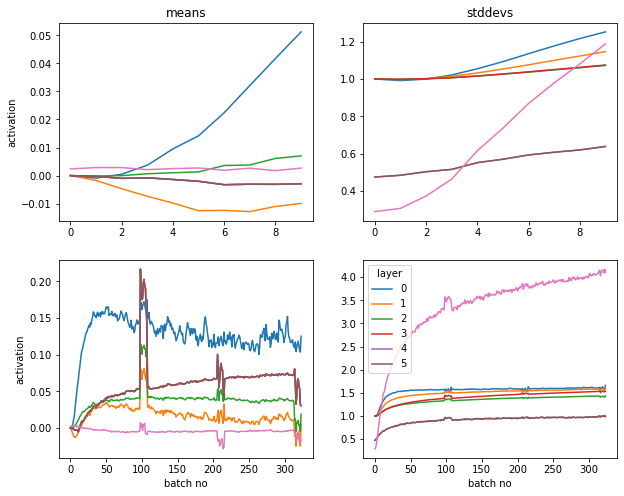

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
for h in hooks:
    means, stds, _ = h.stats
    ax[0,0].plot(means[:10]); ax[0,1].plot(stds[:10])
    ax[1,0].plot(means); ax[1,1].plot(stds)
    ax[0,0].set_title('means'); ax[0,1].set_title('stddevs')
    for a in ax[1]: a.set_xlabel('batch no')
    for a in ax[:, 0]: a.set_ylabel('activation')
    plt.legend(range(6), title='layer')

In [12]:
sched = combine_schedules([0.5, 0.5],
                          [sched_cosine(0.1, 1.2),
                           sched_cosine(1.2, 0.2)]) 

# add annealing callbacks
cbs = [BatchTransformCB(mnist_view),
       Recorder(),
       AvgStatsCB([acc_f]),
       ParamScheduler('lr', sched)]

job = DLJob(cbs)

In [13]:
with Hooks(model, append_stats_hist_GReLU) as hooks: job.fit(3, model_w)

train: [0.964600546875, tensor(0.7300)]
valid: [0.260396826171875, tensor(0.9193)]
train: [0.17809373046875, tensor(0.9462)]
valid: [0.1294649658203125, tensor(0.9625)]
train: [0.1079597265625, tensor(0.9678)]
valid: [0.100742041015625, tensor(0.9706)]


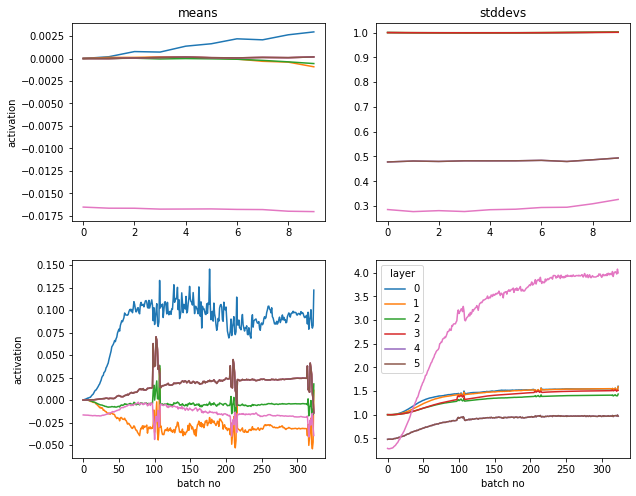

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
for h in hooks:
    means, stds, _ = h.stats
    ax[0,0].plot(means[:10]); ax[0,1].plot(stds[:10])
    ax[1,0].plot(means); ax[1,1].plot(stds)
    ax[0,0].set_title('means'); ax[0,1].set_title('stddevs')
    for a in ax[1]: a.set_xlabel('batch no')
    for a in ax[:, 0]: a.set_ylabel('activation')
    plt.legend(range(6), title='layer')

### Something weird happens at the end of each epoch...
The means appear to jump around... is it the small batch size?

In [55]:
#--export--#
class RunningBatchNorm(nn.Module):
    def __init__(self, n_inp, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.gamma = nn.Parameter(torch.ones (n_inp, 1, 1))
        self.beta  = nn.Parameter(torch.zeros(n_inp, 1, 1))
        self.register_buffer('sums', torch.zeros(1,n_inp,1,1))
        self.register_buffer('sqrs', torch.zeros(1,n_inp,1,1))
        self.register_buffer('batch', torch.tensor(0.))
        self.register_buffer('count', torch.tensor(0.))
        self.register_buffer('step',  torch.tensor(0.))
        self.register_buffer('dbias', torch.tensor(0.))
        
    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0, 2, 3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.gamma).add_(self.beta)

In [56]:
#--export--#
def conv_GReLU(n_inp, n_out, kernel_size=3, stride=2, btch_norm='running', **kwargs):
    layers = [nn.Conv2d(n_inp, n_out,
                       kernel_size,
                       padding=kernel_size//2,
                       stride=stride,
                       bias = not btch_norm),
              GReLU(**kwargs)]
    if btch_norm == 'regular': layers.append(RunningBatchNorm(n_out))
    if btch_norm == 'running': layers.append(RunningBatchNorm(n_out))
    
    return nn.Sequential(*layers)

In [69]:
GReLU_params = {'leak': 0.1, 'sub': 0.3, 'maxv': 6.}

kernel_ns = [8, 16, 32, 32]
data_w = MNISTDataWrapper()
model = nn.Sequential(*cnn_layers_GReLU(data_w, kernel_ns, **GReLU_params))
model_w = ModelWrapper(model,
                       optim.SGD(model.parameters(), lr=0.4),
                       torch.functional.F.cross_entropy,
                       data_w)

for l in model:
    if isinstance(l, nn.Sequential):
        torch.nn.init.kaiming_uniform_(l[0].weight)
        if getattr(l[0], 'bias', None) is not None: l[0].bias.data.zero_()

sched = combine_schedules([0.6, 0.4],
                          [sched_cosine(0.3, 1.5),
                           sched_cosine(1.5, 0.3)]) 

# add annealing callbacks
cbs = [BatchTransformCB(mnist_view),
       Recorder(),
       AvgStatsCB([acc_f]),
       ParamScheduler('lr', sched)]

job = DLJob(cbs)

In [70]:
with Hooks(model, append_stats_hist_GReLU) as hooks: job.fit(3, model_w)

train: [0.5986809765625, tensor(0.8364)]
valid: [0.1752545166015625, tensor(0.9498)]
train: [0.12116240234375, tensor(0.9633)]
valid: [0.08722496337890626, tensor(0.9734)]
train: [0.0638124169921875, tensor(0.9806)]
valid: [0.06041898193359375, tensor(0.9831)]


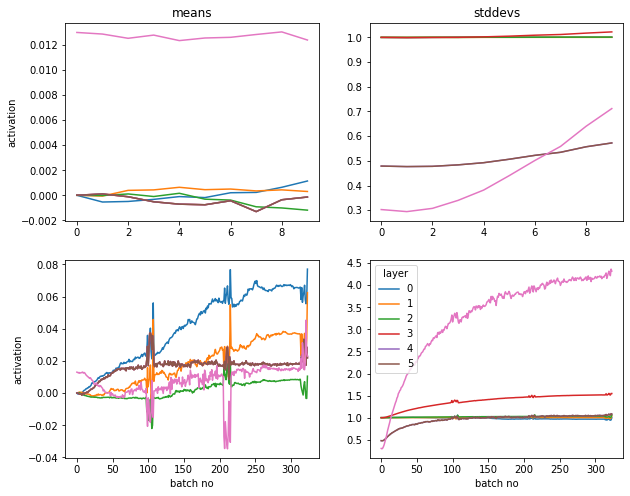

In [71]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
for h in hooks:
    means, stds, _ = h.stats
    ax[0,0].plot(means[:10]); ax[0,1].plot(stds[:10])
    ax[1,0].plot(means); ax[1,1].plot(stds)
    ax[0,0].set_title('means'); ax[0,1].set_title('stddevs')
    for a in ax[1]: a.set_xlabel('batch no')
    for a in ax[:, 0]: a.set_ylabel('activation')
    plt.legend(range(6), title='layer')

In [72]:
with Hooks(model, append_stats_hist_GReLU) as hooks: job.fit(3, model_w)

train: [0.047810126953125, tensor(0.9858)]
valid: [0.06596661987304688, tensor(0.9806)]
train: [0.0560109814453125, tensor(0.9825)]
valid: [0.083109033203125, tensor(0.9743)]
train: [0.03675452392578125, tensor(0.9889)]
valid: [0.04814344177246094, tensor(0.9865)]


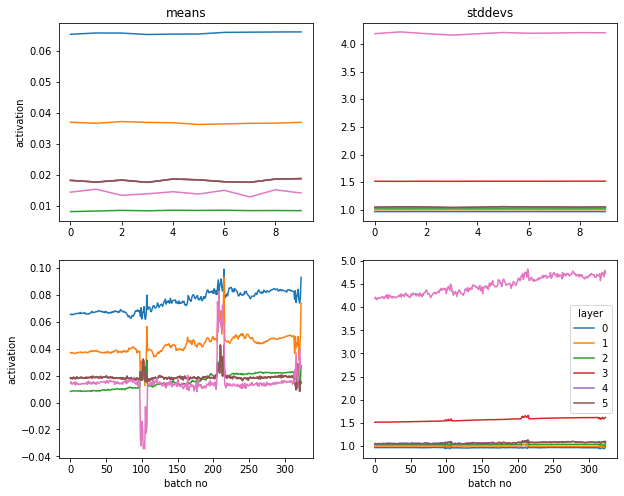

In [73]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
for h in hooks:
    means, stds, _ = h.stats
    ax[0,0].plot(means[:10]); ax[0,1].plot(stds[:10])
    ax[1,0].plot(means); ax[1,1].plot(stds)
    ax[0,0].set_title('means'); ax[0,1].set_title('stddevs')
    for a in ax[1]: a.set_xlabel('batch no')
    for a in ax[:, 0]: a.set_ylabel('activation')
    plt.legend(range(6), title='layer')

In [75]:
!python utils/export_notebook.py 13_BatchNorm.ipynb

Notebook 13_BatchNorm.ipynb has been converted to module ./exports/e_13_BatchNorm.py!
